In [1]:
import os
import numpy as np

image_paths = []
for filename in os.listdir('images'):
    if filename.endswith(".jpg"):
        image_paths.append(filename)
    else:
        continue

In [2]:
from PIL import Image

images = []

for image_path in image_paths:
    # load the image
    images.append(np.array(Image.open('images/' + image_path).convert('RGB')))

In [3]:
from imagecorruptions import corrupt
import tqdm

images_corrupted = []
for image in tqdm.tqdm(images):
    corrupt_amount = np.random.randint(0, 6)
    if corrupt_amount != 0:
        images_corrupted.append(corrupt(image, corruption_name='shot_noise', severity=corrupt_amount))
    else:
        images_corrupted.append(image)

100%|██████████| 2046/2046 [00:38<00:00, 52.78it/s]


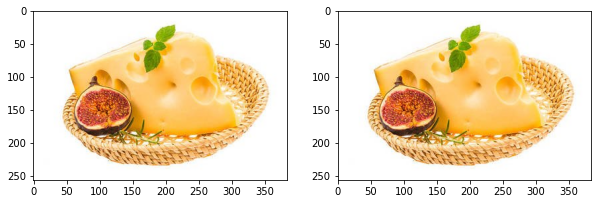

In [4]:
# display 1 of the corrupted images with the original
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(images[0])
plt.subplot(1, 2, 2)
plt.imshow(images_corrupted[0])


In [5]:
# resize the images to 128x128
image_size = (64, 64, 3)
from skimage.transform import resize

for i in tqdm.tqdm(range(len(images))):
    images[i] = resize(images[i], image_size)
    images_corrupted[i] = resize(images_corrupted[i], image_size)

100%|██████████| 2046/2046 [00:24<00:00, 82.38it/s]


In [6]:
# split the data into train and test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images_corrupted, images, test_size=0.2, random_state=43)

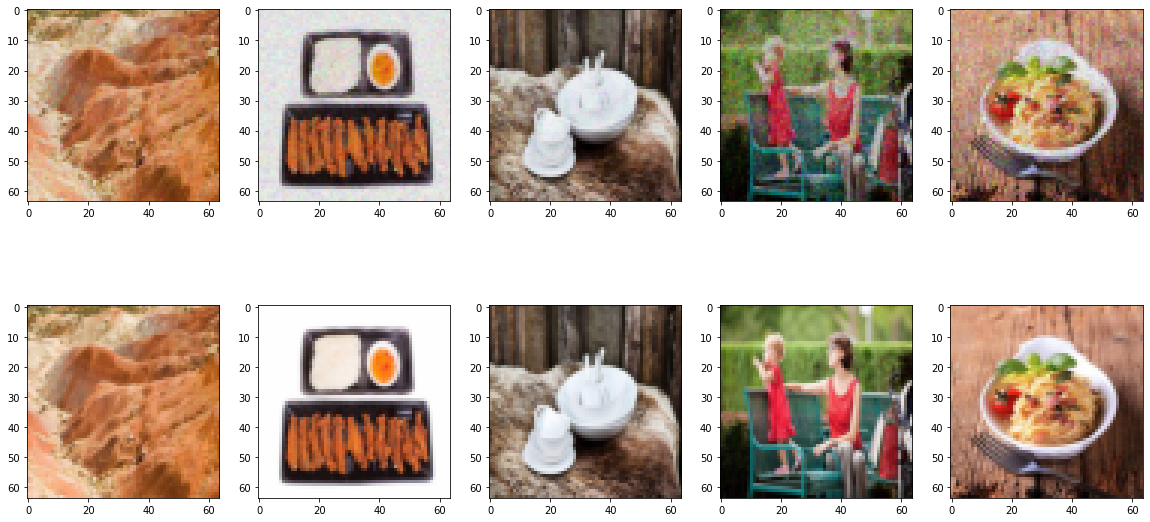

In [7]:
import matplotlib.pyplot as plt

# plot the images and their corrupted versions
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(0, 5):
    axs[0, i].imshow(x_train[i])
    axs[1, i].imshow(y_train[i])
plt.show()

In [8]:
# create the dataset from the images and their corrupted versions
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat()
dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).repeat()

dataset = dataset.shuffle(buffer_size=len(x_train)).batch(1)
dataset_test = dataset_test.batch(1)

2022-08-29 23:57:57.166204: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-29 23:57:58.432029: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-29 23:57:58.942229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30980 MB memory:  -> device: 0, name: Quadro GV100, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [9]:
import keras as ks
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, BatchNormalization, Activation, InputLayer, LeakyReLU, GlobalMaxPooling2D, Resizing, Conv2DTranspose

# Create the discriminator.
discriminator = ks.Sequential(
    [
        InputLayer(image_size),
        Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        LeakyReLU(alpha=0.2),
        GlobalMaxPooling2D(),
        Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

# Create the generator. This takes in an image and outputs a denoised image.
generator = ks.Sequential(
    [
        InputLayer(image_size),
        # gan generator model that outputs a denoised image
        Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(64, (3, 3), strides=(2, 2), padding="same"),

        LeakyReLU(alpha=0.2),

        UpSampling2D((2, 2)),
        Conv2D(32, (3, 3), padding="same"),
        LeakyReLU(alpha=0.2),
        UpSampling2D((2, 2)),
        Conv2D(3, (3, 3), padding="same"),
        BatchNormalization(),
        Activation("tanh"),
        

    ],
    name="generator",
)

In [10]:
class ConditionalGAN(ks.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = ks.metrics.Mean(name="gen_loss")
        self.disc_loss_tracker = ks.metrics.Mean(name="disc_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, d_loss, g_loss, run_eagerly=False):
        super(ConditionalGAN, self).compile(run_eagerly=run_eagerly)
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss = d_loss
        self.g_loss = g_loss

    def train_step(self, data):

        # Unpack the data.
        corrupted_images, original_images = data
        print(corrupted_images.shape)
        batch_size = tf.shape(corrupted_images)[0]
        print("The Batch size is ", batch_size)

        # reshape the corrupted images to have a shape of (batch_size, 128, 128, 3)
        corrupted_images = tf.reshape(corrupted_images, (-1, image_size[0], image_size[1], image_size[2]))
        original_images = tf.reshape(original_images, (-1, image_size[0], image_size[1], image_size[2]))

        generated_images = self.generator(corrupted_images)
        generated_images = tf.cast(generated_images, tf.float64)

        generated_images = tf.reshape(generated_images, (-1, image_size[0], image_size[1], image_size[2]))

        # Put the real images and the generated images together. 
        combined_images = tf.concat((generated_images, original_images), axis=0)
        # Create labels for the real and fake images.
        labels = tf.concat((tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))), axis=0)

        # Shuffle the images and the labels the same way by using the indices.
        indices = tf.range(start=0, limit=tf.shape(combined_images)[0], dtype=tf.int32)
        idx = tf.random.shuffle(indices)

        combined_images = tf.gather(combined_images, idx)
        labels = tf.gather(labels, idx)

        print("Training the discriminator")
        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            print("Calculating the loss")
            print(tf.shape(predictions))
            print(tf.shape(labels))
            labels = tf.reshape(labels, (-1, 1))
            predictions = tf.reshape(predictions, (-1, 1))
            d_loss = self.d_loss(labels, predictions)
        print("Tape gradient")
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        print("Updating the discriminator weights")
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        print("Training the generator")
        # Train the generator.
        with tf.GradientTape() as tape:
            fake_images = self.generator(corrupted_images)
            print("Generated Fakes")
            print(tf.shape(fake_images))
            print("Detecting the fake images")
            predictions = self.discriminator(fake_images)
            print("Calculating the loss")
            g_loss = self.g_loss(tf.zeros(batch_size), predictions)

        print("Tape gradient")
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        print("Updating the generator weights")
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update the metrics.
        print("Updating the metrics")
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        print("Finished Epoch")
        return {
            "gen_loss": self.gen_loss_tracker.result(),
            "disc_loss": self.disc_loss_tracker.result(),
        }

In [11]:
# wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)


cond_gan = ConditionalGAN(discriminator, generator, latent_dim=128)
cond_gan.compile(
    run_eagerly=False,
    d_optimizer=ks.optimizers.Adam(learning_rate=0.00001),
    g_optimizer=ks.optimizers.Adam(learning_rate=0.00001),
    g_loss=ks.losses.MeanSquaredError(),
    d_loss=ks.losses.BinaryCrossentropy(from_logits=True),
)

hist = cond_gan.fit(dataset, epochs=100, steps_per_epoch=len(x_train) // 32)


Epoch 1/100
(None, 64, 64, 3)
The Batch size is  Tensor("strided_slice:0", shape=(), dtype=int32)
Training the discriminator
Calculating the loss
Tensor("Shape_2:0", shape=(2,), dtype=int32)
Tensor("Shape_3:0", shape=(2,), dtype=int32)
Tape gradient
Updating the discriminator weights
Training the generator
Generated Fakes
Tensor("Shape_4:0", shape=(4,), dtype=int32)
Detecting the fake images
Calculating the loss
Tape gradient
Updating the generator weights
Updating the metrics
Finished Epoch
(None, 64, 64, 3)
The Batch size is  Tensor("strided_slice:0", shape=(), dtype=int32)
Training the discriminator
Calculating the loss
Tensor("Shape_2:0", shape=(2,), dtype=int32)
Tensor("Shape_3:0", shape=(2,), dtype=int32)
Tape gradient
Updating the discriminator weights
Training the generator
Generated Fakes
Tensor("Shape_4:0", shape=(4,), dtype=int32)
Detecting the fake images
Calculating the loss
Tape gradient
Updating the generator weights
Updating the metrics
Finished Epoch


2022-08-29 23:58:18.400844: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-08-29 23:58:18.860964: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


51/51 [==============================] - 3s 10ms/step - gen_loss: 0.2687 - disc_loss: 0.7115
Epoch 2/100
51/51 [==============================] - 0s 10ms/step - gen_loss: 0.2589 - disc_loss: 0.7020
Epoch 3/100
51/51 [==============================] - 1s 11ms/step - gen_loss: 0.2535 - disc_loss: 0.6931
Epoch 4/100
51/51 [==============================] - 1s 10ms/step - gen_loss: 0.2493 - disc_loss: 0.6858
Epoch 5/100
51/51 [==============================] - 0s 9ms/step - gen_loss: 0.2450 - disc_loss: 0.6801
Epoch 6/100
51/51 [==============================] - 1s 10ms/step - gen_loss: 0.2403 - disc_loss: 0.6722
Epoch 7/100
51/51 [==============================] - 1s 10ms/step - gen_loss: 0.2335 - disc_loss: 0.6669
Epoch 8/100
51/51 [==============================] - 1s 10ms/step - gen_loss: 0.2221 - disc_loss: 0.6575
Epoch 9/100
51/51 [==============================] - 1s 10ms/step - gen_loss: 0.1983 - disc_loss: 0.6461
Epoch 10/100
51/51 [==============================] - 1s 10ms/step -

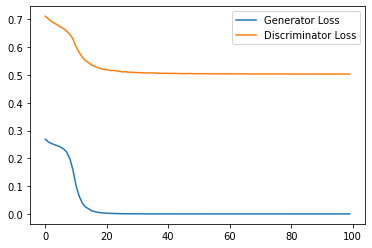

In [12]:
# Plot the losses.
plt.plot(hist.history["gen_loss"], label="Generator Loss")
plt.plot(hist.history["disc_loss"], label="Discriminator Loss")
plt.legend()
plt.show()

1/1 [==============================] - 0s 27ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


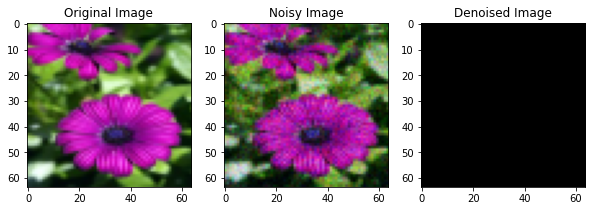

In [15]:
noisy_image = dataset_test.take(1)

denoised_image = cond_gan.generator.predict(noisy_image)

for i in noisy_image.as_numpy_iterator():
    noisy_image, original_image = i

    # show the original image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image[0])

    # show the noisy image
    plt.subplot(1, 3, 2)
    plt.title("Noisy Image")
    plt.imshow(noisy_image[0])

    # show the denoised image
    plt.subplot(1, 3, 3)
    plt.title("Denoised Image")
    plt.imshow(denoised_image[0])



    


In [14]:
# predict if the image is real or fake
predictions = cond_gan.discriminator.predict(noisy_image)
print(predictions)

1/1 [==============================] - 0s 60ms/step
[[0.99844176]]
